##### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

##### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

- Using the `image_dataset_from_directory` function in TensorFlow doesn't allow you to specify exact numbers of images for each subset. Instead, it uses percentages (fractions) of the total dataset.

- The reason why both the validation and test datasets were labeled as "validation" in the subset parameter is that the `image_dataset_from_directory` function in TensorFlow only supports two predefined options for the subset argument: "training" and "validation". 

In [4]:
def load_dataset_with_split(data_dir, img_size=(256, 256), batch_size=32, val_split=0.2, test_split=0.1, seed=123):
    # Calculate split sizes
    train_val_split = 1 - test_split
    val_split_adjusted = val_split / train_val_split  # Adjust validation split

    # Training dataset
    train_dataset = image_dataset_from_directory(
        data_dir,
        validation_split=val_split_adjusted,
        subset="training",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
    )

    # Validation dataset
    validation_dataset = image_dataset_from_directory(
        data_dir,
        validation_split=val_split_adjusted,
        subset="validation",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
    )

    # Test dataset (remaining data)
    test_dataset = image_dataset_from_directory(
        data_dir,
        validation_split=test_split,
        subset="validation",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
    )

    return train_dataset, validation_dataset, test_dataset

data_dir = "PlantVillage"
# Load datasets
train_dataset, validation_dataset, test_dataset = load_dataset_with_split(data_dir)

Found 2152 files belonging to 3 classes.
Using 1674 files for training.
Found 2152 files belonging to 3 classes.
Using 478 files for validation.
Found 2152 files belonging to 3 classes.
Using 215 files for validation.


In [10]:
# Verify the number of classes
class_names = train_dataset.class_names
print(f'Found {len(class_names)} classes: {class_names}')

Found 3 classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


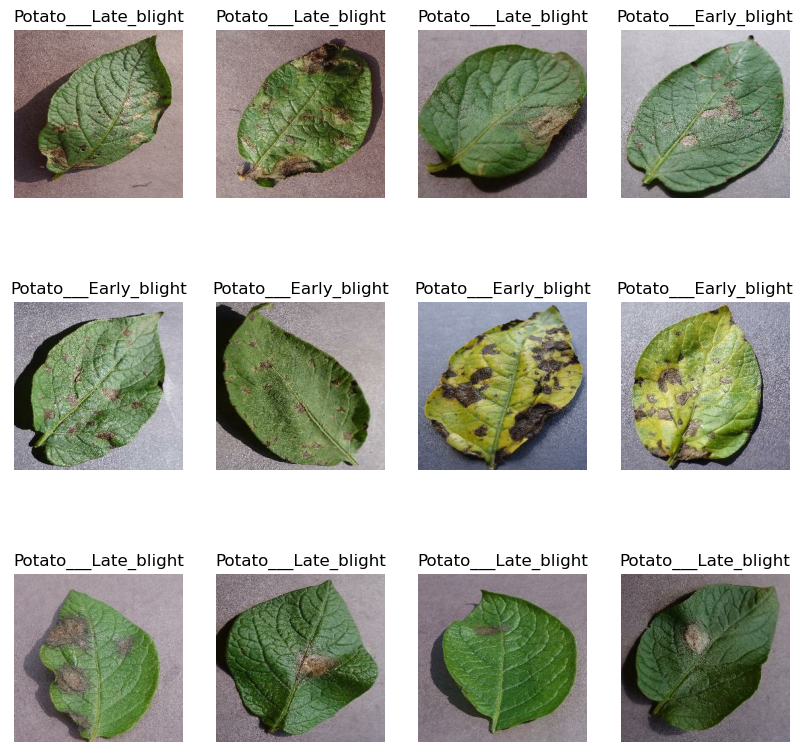

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(train_dataset)

54

##### Cache, Shuffle, and Prefetch the Dataset

In [11]:
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

##### Building the Model

In [13]:
# Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [14]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

##### Model Architecture

In [21]:
n_classes = 3

# Input shape should exclude the batch size
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Define the model
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Add the Input layer here
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [22]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

##### Compiling the Model

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
# TensorBoard callback setup
log_dir = "logs/fit" 
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


##### Measure training time

In [29]:
import time
# Measure training time
start_time = time.time()

##### Training Model

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[tensorboard_callback],
)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 594ms/step - accuracy: 0.9871 - loss: 0.0393 - val_accuracy: 0.9916 - val_loss: 0.0433
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 597ms/step - accuracy: 0.9951 - loss: 0.0139 - val_accuracy: 0.9833 - val_loss: 0.0450
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - accuracy: 0.9930 - loss: 0.0138 - val_accuracy: 0.9728 - val_loss: 0.0695
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 599ms/step - accuracy: 0.9983 - loss: 0.0058 - val_accuracy: 0.9854 - val_loss: 0.0397
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 587ms/step - accuracy: 0.9886 - loss: 0.0321 - val_accuracy: 0.9477 - val_loss: 0.1164
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 593ms/step - accuracy: 0.9985 - loss: 0.0130 - val_accuracy: 0.9895 - val_loss: 0.0263
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 585ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9519 - val_loss: 0.1442
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 587ms/step - accuracy: 0.9932 - loss: 0.0239 - val_accu

In [31]:
end_time = time.time()

training_time = end_time - start_time
print(f"Training time : {training_time} seconds")

Training time : 1604.6347880363464 seconds


In [32]:
scores = model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9982 - loss: 0.0044


##### Plotting the Accuracy and Loss Curves

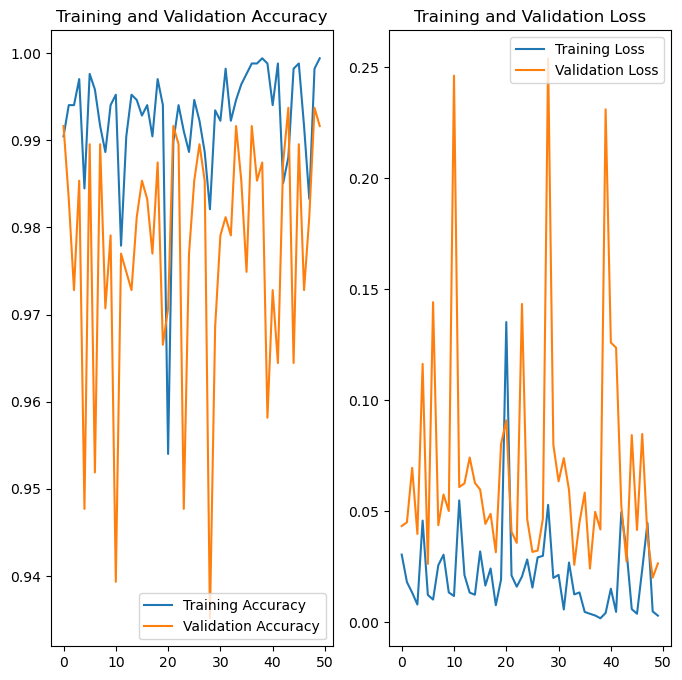

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Tensorboard

In [34]:
%load_ext tensorboard
%tensorboard --logdir logs/fit


##### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
predicted label: Potato___Late_blight


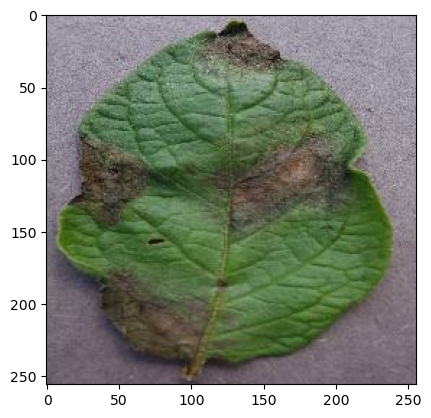

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


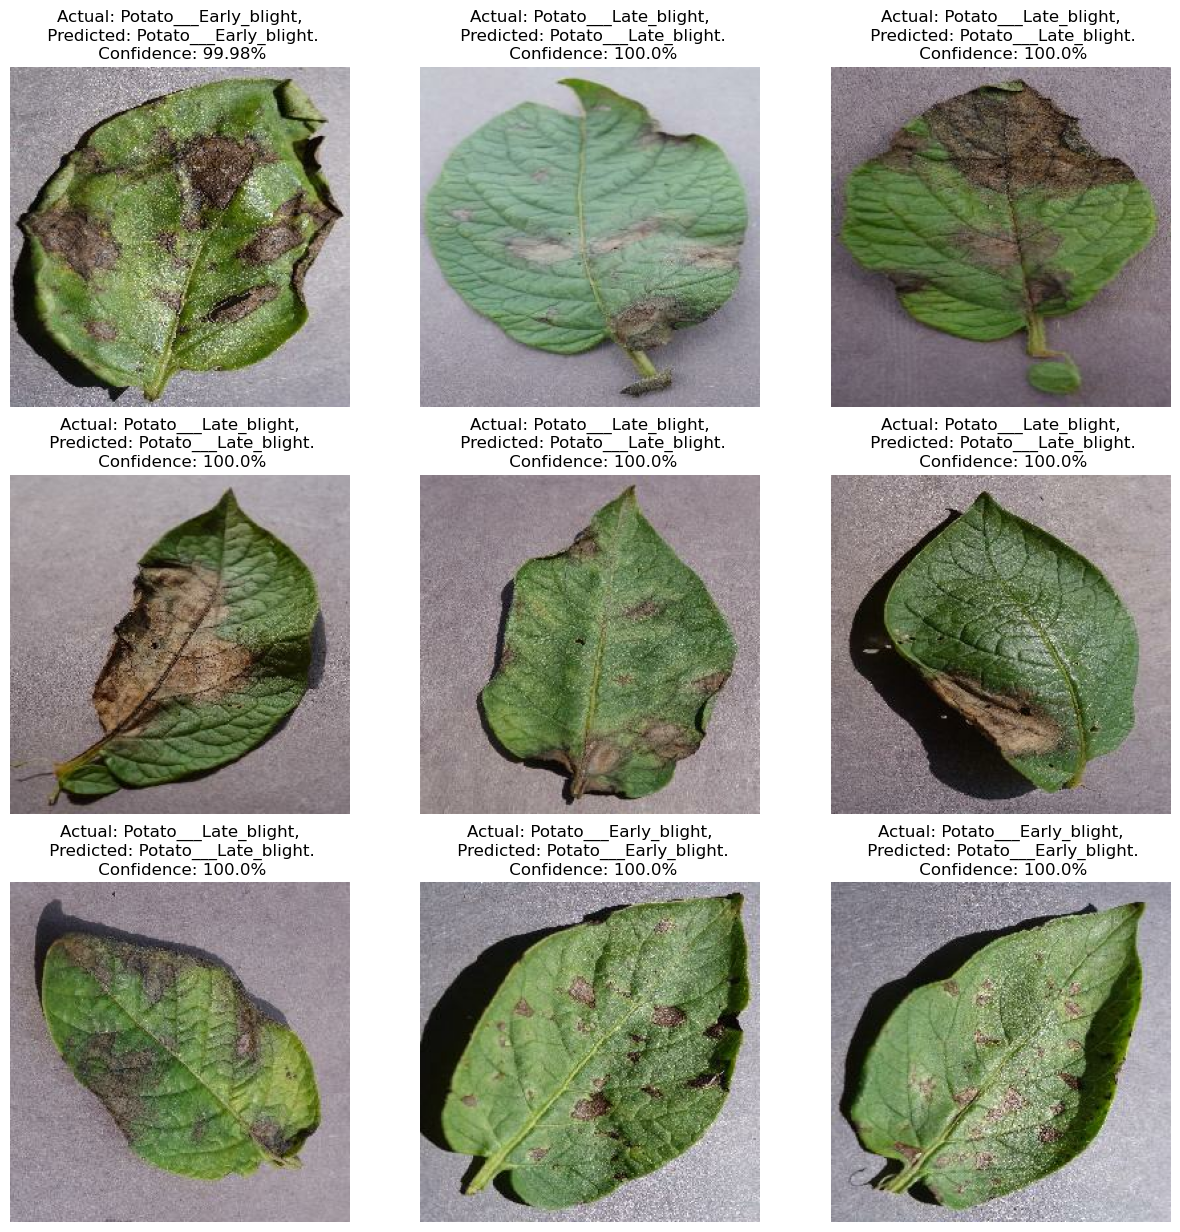

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

##### Saving the Model

In [45]:
import os

# Define the directory path and file extension
models_dir = "../Potato Disease/models"
file_extension = ".keras"  # You can also use ".h5" if preferred

# Create the directory if it does not exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Determine the next model version
try:
    # List directories or files in the models directory
    existing_versions = [int(i) for i in os.listdir(models_dir) if i.isdigit()]
    model_version = max(existing_versions + [0]) + 1
except FileNotFoundError:
    # If the directory is not found, set version to 1
    model_version = 1

# Construct the file path with the correct extension
file_path = f"{models_dir}/{model_version}{file_extension}"

# Save the model
model.save(file_path)

print(f"Model saved to {file_path}")


Model saved to ../Potato Disease/models/1.keras
